In [1]:
# import tensorflow.compat.v1 as tf
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

import cv2
import numpy as np
import os
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
# tf.disable_eager_execution()

%load_ext tensorboard

# Some modules to display an animation using imageio.
import imageio
from IPython import display

In [2]:
tf.__version__

'2.7.0'

In [3]:
# Loading TF Hub module
tiny_vid_model_handle = 'https://tfhub.dev/google/tiny_video_net/tvn2/1'
model = hub.load(tiny_vid_model_handle).signatures['default']

In [8]:
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(256, 256)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

In [9]:
def predict(sample_video):
    # Add a batch axis to the sample video.
    model_input = tf.constant(sample_video, dtype=tf.float32)
    return model(model_input)

In [10]:
video_path = os.path.join("videos", "no_move", "21.mp4")
video_test = load_video(video_path)
# Take the first 16 frames to match the model's expected input shape.
video_test = video_test[:16]
predictions = predict(video_test)
predictions

{'default': <tf.Tensor: shape=(8, 157), dtype=float32, numpy=
 array([[-1.5303063, -2.2290378, -2.192827 , ..., -1.727553 , -2.013451 ,
         -2.7332535],
        [-1.368607 , -2.1288114, -2.0185683, ..., -1.7425112, -2.040703 ,
         -2.792994 ],
        [-1.4521141, -2.1494627, -2.1745145, ..., -2.1871443, -1.8223829,
         -2.8795538],
        ...,
        [-1.3230087, -1.9451172, -2.088139 , ..., -2.1758916, -1.5395231,
         -2.9915137],
        [-1.5134289, -2.0858514, -2.2328975, ..., -2.0432553, -1.7449524,
         -2.9254851],
        [-1.553729 , -2.1540284, -2.1946926, ..., -2.2153542, -1.8332084,
         -2.8775306]], dtype=float32)>}

In [11]:
# Load charades class labels
with open('charades_classes.txt', 'r') as f:
    CLASSES = [line.strip() for line in f.readlines()]
CLASSES

['c000 Holding some clothes',
 'c001 Putting clothes somewhere',
 'c002 Taking some clothes from somewhere',
 'c003 Throwing clothes somewhere',
 'c004 Tidying some clothes',
 'c005 Washing some clothes',
 'c006 Closing a door',
 'c007 Fixing a door',
 'c008 Opening a door',
 'c009 Putting something on a table',
 'c010 Sitting on a table',
 'c011 Sitting at a table',
 'c012 Tidying up a table',
 'c013 Washing a table',
 'c014 Working at a table',
 'c015 Holding a phone/camera',
 'c016 Playing with a phone/camera',
 'c017 Putting a phone/camera somewhere',
 'c018 Taking a phone/camera from somewhere',
 'c019 Talking on a phone/camera',
 'c020 Holding a bag',
 'c021 Opening a bag',
 'c022 Putting a bag somewhere',
 'c023 Taking a bag from somewhere',
 'c024 Throwing a bag somewhere',
 'c025 Closing a book',
 'c026 Holding a book',
 'c027 Opening a book',
 'c028 Putting a book somewhere',
 'c029 Smiling at a book',
 'c030 Taking a book from somewhere',
 'c031 Throwing a book somewhere',
 

In [12]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  return embed.embed_file('./animation.gif')

def convert_prediction_to_classes(predictions):
    logits = predictions['default'][0]

    probabilities = tf.nn.softmax(logits)
    for i in np.argsort(probabilities)[::-1][:5]:
        print(f"  {CLASSES[i]:22}: {probabilities[i] * 100:5.2f}%")



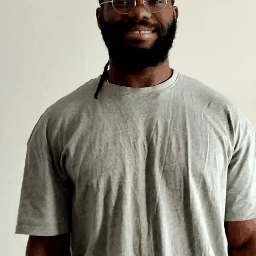

In [13]:
to_gif(video_test)

In [14]:
convert_prediction_to_classes(predictions)

  c072 Snuggling with a blanket:  2.77%
  c070 Holding a blanket:  2.53%
  c115 Someone is holding a paper/notebook:  2.16%
  c152 Someone is smiling:  2.04%
  c040 Holding a box    :  1.96%
